# Comparando pipelines

Incluye:

- Tuning de hyperparámetros (con meses históricos)
- Comparación de distintos pipelines

In [1]:
!pip install dask[dataframe]

In [2]:
# Librerias
import os
import pandas as pd
import numpy as np

#######
# rutas
# datasets
from config import dataset_file_fe6_6pqt
# optimizacion
from config import db_path
# modelos
from config import modelos_path
# predicciones
from config import pred_path

##########
# pipeline
from processing import ModelPipeline, plot_comparisons_on_kaggle_split
from processing import analyze_study
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import optuna
import warnings

# Ignorar advertencias de tipo UserWarning
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')
warnings.filterwarnings('ignore', category=Warning, module='lightgbm')
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')
warnings.filterwarnings('ignore', category=Warning, module='xgboost')
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')


Variables de train y test

In [3]:
ganancia_acierto = 273000
costo_estimulo = 7000

mes_train_all = [201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908,
                 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004,
                 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106]

mes_train_ult_3_meses = [202104, 202105, 202106]

mes_train_ult_6_meses = [202101, 202102, 202103, 202104, 202105, 202106]

mes_train_ult_9_meses = [202009, 202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105, 202106]

mes_train_ult_anio = [202006, 202007, 202008, 202009, 202010, 202011, 202012,
                 202101, 202102, 202103, 202104, 202105, 202106]

mes_train = [202106]
mes_test = 202108

threshold = 0.025

semillas = [437809, 327347, 392879, 455783, 217163]

## Loading data

In [4]:
# data = pd.read_parquet(dataset_file_fe6_6pqt)

# running local, con 6 meses para train
data = pd.read_parquet("datos/datasets_competencia_02_fe6_6_6m_train.parquet")

# Mapear etiquetas de clase a números
label_mapping = {'CONTINUA': 0, 'BAJA+1': 1, 'BAJA+2': 2}

data['clase_ternaria'] = data['clase_ternaria'].map(label_mapping)

# Simulación para Kaggle
X_train = data[data['foto_mes'].isin([202101, 202102, 202103, 202104])]
y_train = X_train['clase_ternaria']
X_train = X_train.drop(columns=['clase_ternaria'])

mes_futuro = 202106 # usado como test
X_test = data[data['foto_mes'] == mes_futuro]
y_test = X_test['clase_ternaria']
X_test = X_test.drop(columns=['clase_ternaria'])

del data

Preprocesando data

In [5]:
# Imputacion de Xs
cols_with_all_nan = X_train.columns[X_train.isna().all()].tolist()
print("Columns with all NaN values:", cols_with_all_nan)
X_train = X_train.drop(columns=cols_with_all_nan)
X_test = X_test.drop(columns=cols_with_all_nan)

# Imputación de nulls
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp_median.transform(X_test), columns=X_train.columns)

del X_train
del X_test

# Codificar variables categóricas
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Convertir variables categóricas a 'category' dtype para LightGBM
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')
    X_test_imp[col] = X_test_imp[col].astype('category')

Columns with all NaN values: ['payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']


## Modelos candidatos

> lightgbm prepro6 fe6 y 1 opt (cloud opt)

> lightgbm prepro6 fe6 y 3 opt (local opt)

> xgboost prepro6 fe6 y 3 opt (local opt parcial)

### lightgbm prepro6 fe6 y 1 opt (cloud opt) 

**Prepro in 6 months and Conceptual FE 6 months**

comp02_prepro_6.ipynb

comp02_fe6_6.ipynb

**Usando los últimos 1 meses para optimizar**

### Corriendo pipeline con LightGBM ###

# Entrenando el modelo base LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.776872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50980
[LightGBM] [Info] Number of data points in the train set: 652447, number of used features: 405
[LightGBM] [Info] Start training from score -0.011397
[LightGBM] [Info] Start training from score -5.250505
[LightGBM] [Info] Start training from score -5.101460

# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 63308000.0

# Optimizando el modelo


[I 2024-11-20 16:33:15,379] Using an existing study with name 'exp_lgbm_pr6_fe6_tr1' instead of creating a new one.


Mejores parámetros para lightgbm: {'n_estimators': 308, 'num_leaves': 56, 'learning_rate': 0.009314267956770315, 'min_data_in_leaf': 43, 'min_gain_to_split': 0.7199938447034192, 'feature_fraction': 0.6114825370827424, 'bagging_fraction': 0.5803875218732338, 'bagging_freq': 6, 'max_bin': 175}

# Entrenando el mejor modelo con parámetros optimizados
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.6114825370827424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6114825370827424
[LightGBM] [Warning] min_gain_to_split is set=0.7199938447034192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7199938447034192
[LightGBM] [Warning] bagging_fraction is set=0.5803875218732338, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5803875218732338
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be igno

c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


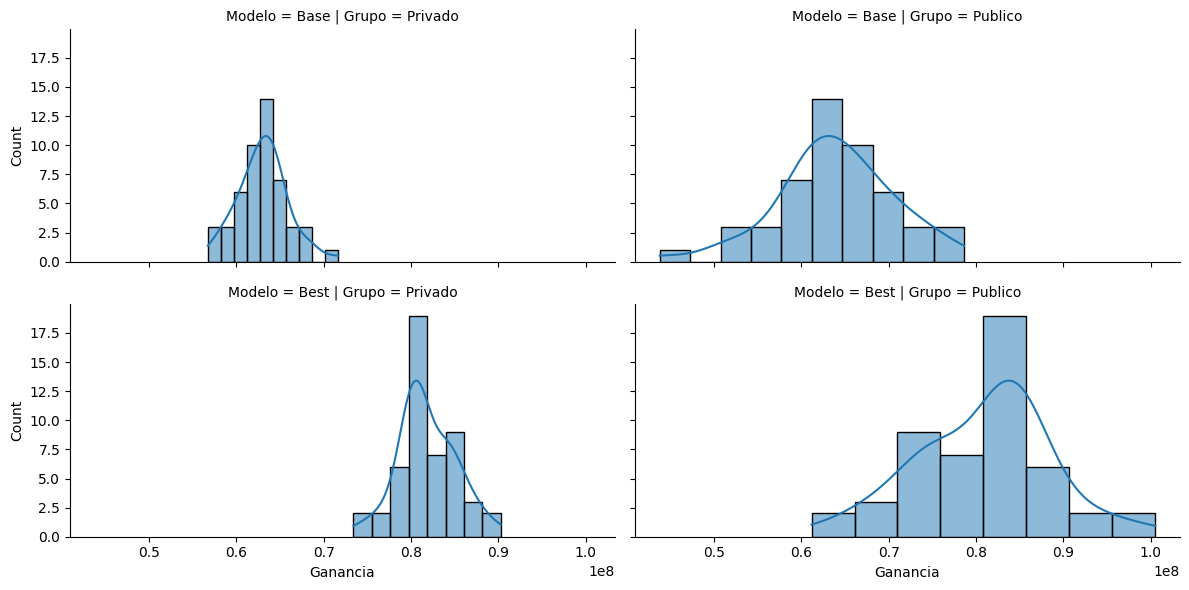

Ganancia media del modelo base en privado: 63063600.0
Ganancia media del modelo base en público: 63878266.66666667
Ganancia media del modelo Best en privado: 81839200.0
Ganancia media del modelo Best en público: 80851866.66666667


In [6]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = 1 # un mes de optimización

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_lgbm = ModelPipeline(data=None, seeds=semillas,
                              model_type='lightgbm', seed=s, n_jobs=-1)

print("\n# Entrenando el modelo base LightGBM")
pipeline_lgbm.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_lgbm.test_base_model(X_test_imp, y_test)

# Definir el almacenamiento para Optuna
# storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
storage_name = "sqlite:///optimizacion/optimization_lgbm.db"

study_name = f"exp_lgbm_pr{prepro}_fe{fe}_tr{training}"

print("\n# Optimizando el modelo")
pipeline_lgbm.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_name,
    study_name=study_name,
    optimize=False,  
    n_trials=100
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_lgbm.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_lgbm.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_pr6_fe6_tr1, fpri_base_lgbm_pr6_fe6_tr1, \
fpub_best_lgbm_pr6_fe6_tr1, fpub_base_lgbm_pr6_fe6_tr1 = \
pipeline_lgbm.simulate_kaggle_split(X_test_imp, y_test) # sin imputer ni to_drop porque estan prepro

Exploring optimization

In [7]:
study = analyze_study(storage_name, study_name)


Study Trials DataFrame:

|    |   number |         value | datetime_start             | datetime_complete          | duration               |   params_bagging_fraction |   params_bagging_freq |   params_feature_fraction |   params_learning_rate |   params_max_bin |   params_min_data_in_leaf |   params_min_gain_to_split |   params_n_estimators |   params_num_leaves | state    |
|---:|---------:|--------------:|:---------------------------|:---------------------------|:-----------------------|--------------------------:|----------------------:|--------------------------:|-----------------------:|-----------------:|--------------------------:|---------------------------:|----------------------:|--------------------:|:---------|
|  0 |        0 |   3.73147e+07 | 2024-11-18 19:24:03.501328 | 2024-11-18 20:47:03.547505 | 0 days 01:23:00.046177 |                  0.830329 |                     4 |                  0.562778 |             0.122532   |              203 |                        

In [8]:
optuna.visualization.plot_optimization_history(study)

In [9]:
optuna.visualization.plot_param_importances(study)

In [10]:
optuna.visualization.plot_slice(study)

### lightgbm prepro6 fe6 y 3 opt (local opt) 

**Prepro in 6 months and Conceptual FE 6 months**

comp02_prepro_6.ipynb

comp02_fe6_6.ipynb

**Usando los últimos 3 meses para optimizar**

### Corriendo pipeline con LightGBM ###

# Entrenando el modelo base LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.623966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50980
[LightGBM] [Info] Number of data points in the train set: 652447, number of used features: 405
[LightGBM] [Info] Start training from score -0.011397
[LightGBM] [Info] Start training from score -5.250505
[LightGBM] [Info] Start training from score -5.101460

# Evaluando el modelo base en el conjunto de prueba


[I 2024-11-20 16:36:57,994] Using an existing study with name 'exp_lgbm_pr6_fe6_tr3_x' instead of creating a new one.


Ganancia del modelo en el conjunto de test: 63308000.0

# Optimizando el modelo
Mejores parámetros para lightgbm: {'n_estimators': 466, 'num_leaves': 57, 'learning_rate': 0.024563319625208798, 'min_data_in_leaf': 100, 'min_gain_to_split': 0.011030284732349089, 'feature_fraction': 0.5157056981996073, 'bagging_fraction': 0.8424259086760796, 'bagging_freq': 2, 'max_bin': 97}

# Entrenando el mejor modelo con parámetros optimizados
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5157056981996073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5157056981996073
[LightGBM] [Warning] min_gain_to_split is set=0.011030284732349089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011030284732349089
[LightGBM] [Warning] bagging_fraction is set=0.8424259086760796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.84

c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



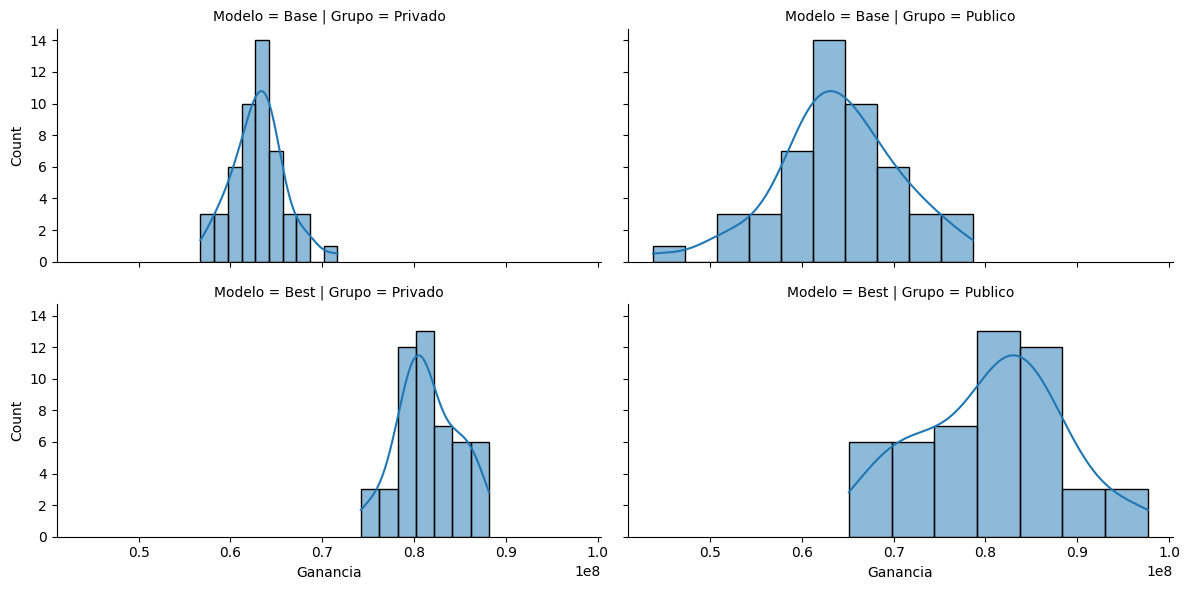

Ganancia media del modelo base en privado: 63063600.0
Ganancia media del modelo base en público: 63878266.66666667
Ganancia media del modelo Best en privado: 81533800.0
Ganancia media del modelo Best en público: 80631133.33333334


In [11]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = 3 # un mes de optimización

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_lgbm_x = ModelPipeline(data=None, seeds=semillas,
                              model_type='lightgbm', seed=s, n_jobs=-3)

print("\n# Entrenando el modelo base LightGBM")
pipeline_lgbm_x.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_lgbm_x.test_base_model(X_test_imp, y_test)

# Definir el almacenamiento para Optuna
# storage_name = "sqlite:///" + db_path + "optimization_tree.db"
storage_name = "sqlite:///optimizacion/optimization_tree.db"
study_name = f"exp_lgbm_pr{prepro}_fe{fe}_tr{training}_x"

print("\n# Optimizando el modelo")
pipeline_lgbm_x.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_name,
    study_name=study_name,
    optimize=False,  
    n_trials=100
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_lgbm_x.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_lgbm_x.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_pr6_fe6_tr3, fpri_base_lgbm_pr6_fe6_tr3, \
fpub_best_lgbm_pr6_fe6_tr3, fpub_base_lgbm_pr6_fe6_tr3 = \
pipeline_lgbm_x.simulate_kaggle_split(X_test_imp, y_test) # sin imputer ni to_drop porque estan prepro

Exploring optimization

In [12]:
study = analyze_study(storage_name, study_name)


Study Trials DataFrame:

|    |   number |       value | datetime_start             | datetime_complete          | duration               |   params_bagging_fraction |   params_bagging_freq |   params_feature_fraction |   params_learning_rate |   params_max_bin |   params_min_data_in_leaf |   params_min_gain_to_split |   params_n_estimators |   params_num_leaves | state    |
|---:|---------:|------------:|:---------------------------|:---------------------------|:-----------------------|--------------------------:|----------------------:|--------------------------:|-----------------------:|-----------------:|--------------------------:|---------------------------:|----------------------:|--------------------:|:---------|
|  0 |        0 | 7.08633e+07 | 2024-11-19 22:39:55.915963 | 2024-11-19 22:43:04.160323 | 0 days 00:03:08.244360 |                  0.618832 |                     3 |                  0.52662  |             0.227994   |              168 |                        57 |  

In [13]:
optuna.visualization.plot_optimization_history(study)

In [14]:
optuna.visualization.plot_param_importances(study)

In [15]:
optuna.visualization.plot_slice(study)

### xgboost prepro6 fe6 y 3 opt (local opt parcial) 

**Prepro in 6 months and Conceptual FE 6 months**

comp02_prepro_6.ipynb

comp02_fe6_6.ipynb

**Usando los últimos 3 meses (parcial) para optimizar**

### Corriendo pipeline con XGBoost ###

# Entrenando el modelo base XGBoost

# Evaluando el modelo base en el conjunto de prueba


[I 2024-11-20 16:42:34,245] Using an existing study with name 'exp_xgb_pr6_fe6_tr3_x' instead of creating a new one.


Ganancia del modelo en el conjunto de test: 81270000.0

# Optimizando el modelo
Mejores parámetros para xgboost: {'n_estimators': 478, 'max_leaves': 174, 'eta': 0.060387545964796806, 'gamma': 0.9866113690542855, 'min_child_weight': 5, 'subsample': 0.7985283659419606, 'colsample_bytree': 0.680777100783857}

# Entrenando el mejor modelo con parámetros optimizados

# Evaluando el mejor modelo en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 87815000.0

# Simulando el split Kaggle y comparando modelos


c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



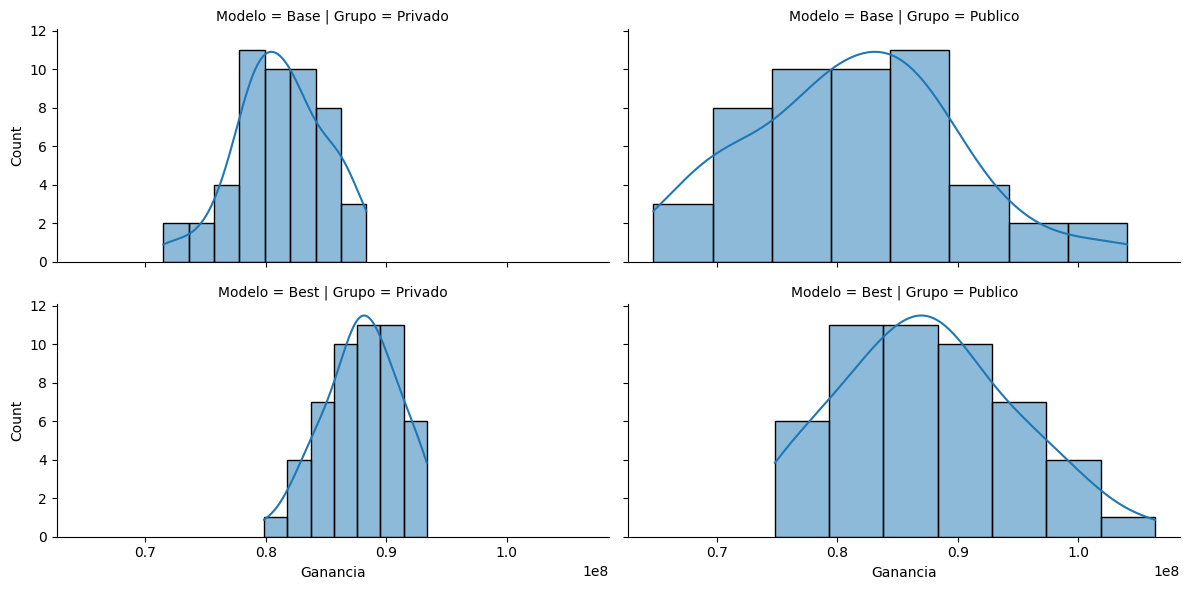

Ganancia media del modelo base en privado: 81240200.0
Ganancia media del modelo base en público: 81339533.33333334
Ganancia media del modelo Best en privado: 87951400.0
Ganancia media del modelo Best en público: 87496733.33333334


In [16]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
training = 3 # un mes de optimización

print("### Corriendo pipeline con XGBoost ###")
# Inicializar el pipeline con 'xgboost'
pipeline_xgb_x = ModelPipeline(data=None, seeds=semillas,
                              model_type='xgboost', seed=s, n_jobs=-3)

print("\n# Entrenando el modelo base XGBoost")
pipeline_xgb_x.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_xgb_x.test_base_model(X_test_imp, y_test)

# Definir el almacenamiento para Optuna
# storage_name = "sqlite:///" + db_path + "optimization_tree.db"
storage_name = "sqlite:///optimizacion/optimization_tree.db"
study_name = f"exp_xgb_pr{prepro}_fe{fe}_tr{training}_x"

print("\n# Optimizando el modelo")
pipeline_xgb_x.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_name,
    study_name=study_name,
    optimize=False,  
    n_trials=100
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_xgb_x.train_best_model(X_train_imp, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_xgb_x.test_best_model(X_test_imp, y_test)

# Simular el split Kaggle y comparar modelos
print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_xgb_pr6_fe6_tr3, fpri_base_xgb_pr6_fe6_tr3, \
fpub_best_xgb_pr6_fe6_tr3, fpub_base_xgb_pr6_fe6_tr3 = \
pipeline_xgb_x.simulate_kaggle_split(X_test_imp, y_test) # sin imputer ni to_drop porque estan prepro

Exploring optimization

In [17]:
study = analyze_study(storage_name, study_name)


Study Trials DataFrame:

|    |   number |         value | datetime_start             | datetime_complete          | duration               |   params_colsample_bytree |   params_eta |   params_gamma |   params_max_leaves |   params_min_child_weight |   params_n_estimators |   params_subsample | state    |
|---:|---------:|--------------:|:---------------------------|:---------------------------|:-----------------------|--------------------------:|-------------:|---------------:|--------------------:|--------------------------:|----------------------:|-------------------:|:---------|
|  0 |        0 | nan           | 2024-11-20 07:54:50.583926 | 2024-11-20 07:55:11.767686 | 0 days 00:00:21.183760 |                  0.787096 |    0.130665  |       0.218265 |                 212 |                         2 |                   406 |           0.77097  | FAIL     |
|  1 |        1 |   3.40354e+08 | 2024-11-20 09:20:54.080034 | 2024-11-20 09:25:01.335416 | 0 days 00:04:07.255382 |         

In [18]:
optuna.visualization.plot_optimization_history(study)

In [19]:
optuna.visualization.plot_param_importances(study)

In [20]:
optuna.visualization.plot_slice(study)

## Comparación de modelos 

Distintos pipelines en sus pruebas de backtesting

Comparando modelos: lgbm prepro6 fe6 y 1 opt (cloud opt)  vs. lgbm prepro6 fe6 y 3 opt (local opt)


c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



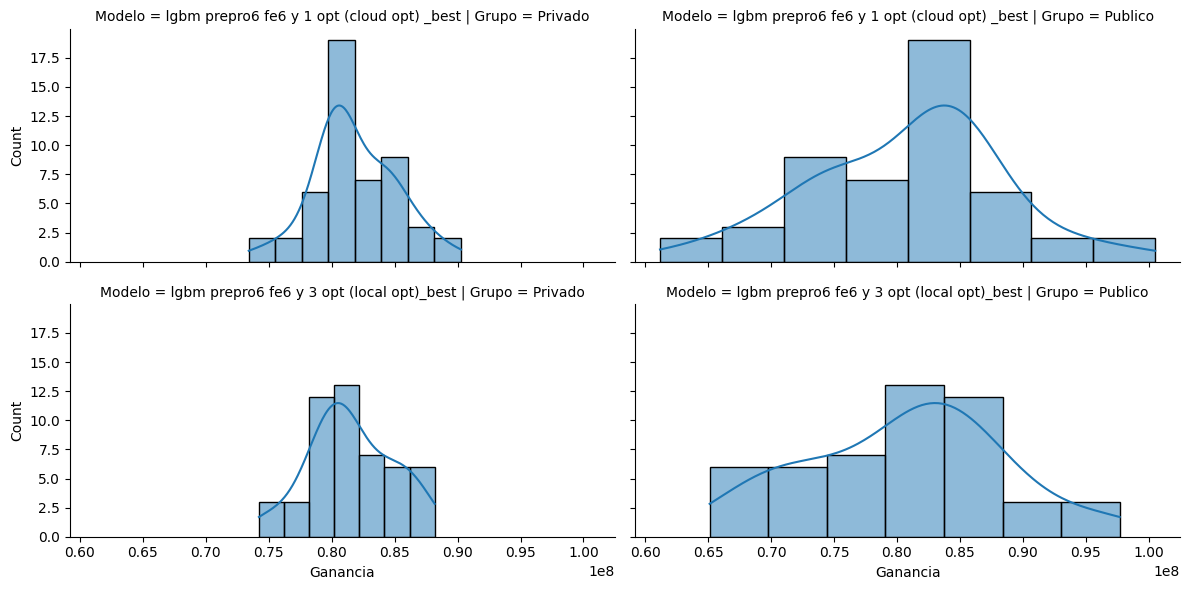

Ganancia media del modelo lgbm prepro6 fe6 y 1 opt (cloud opt)  privado: 81839200.0
Ganancia media del modelo lgbm prepro6 fe6 y 1 opt (cloud opt)  publico: 80851866.66666667
Ganancia media del modelo lgbm prepro6 fe6 y 3 opt (local opt) privado: 81533800.0
Ganancia media del modelo lgbm prepro6 fe6 y 3 opt (local opt) publico: 80631133.33333334

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1313.0
P-valor = 0.6692199334827247
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de lgbm prepro6 fe6 y 3 opt (local opt)_priv es mayor que la de lgbm prepro6 fe6 y 1 opt (cloud opt) _priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1292.5
P-valor = 0.6165511051720214
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de lgbm prepro6 fe6 y 3 opt (local opt)_pub es mayor que la de lgbm prepro6 fe6 y 1 opt (cloud opt) _pub.


In [21]:
model_a = "lgbm prepro6 fe6 y 1 opt (cloud opt) "
model_b = "lgbm prepro6 fe6 y 3 opt (local opt)"

plot_comparisons_on_kaggle_split(model_a, fpri_best_lgbm_pr6_fe6_tr1, fpub_best_lgbm_pr6_fe6_tr1,
                                model_b, fpri_best_lgbm_pr6_fe6_tr3, fpub_best_lgbm_pr6_fe6_tr3)

Comparando modelos: lgbm prepro6 fe6 y 3 opt (local opt)  vs. xgb prepro6 fe6 y 3 opt (local opt parcial)


c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



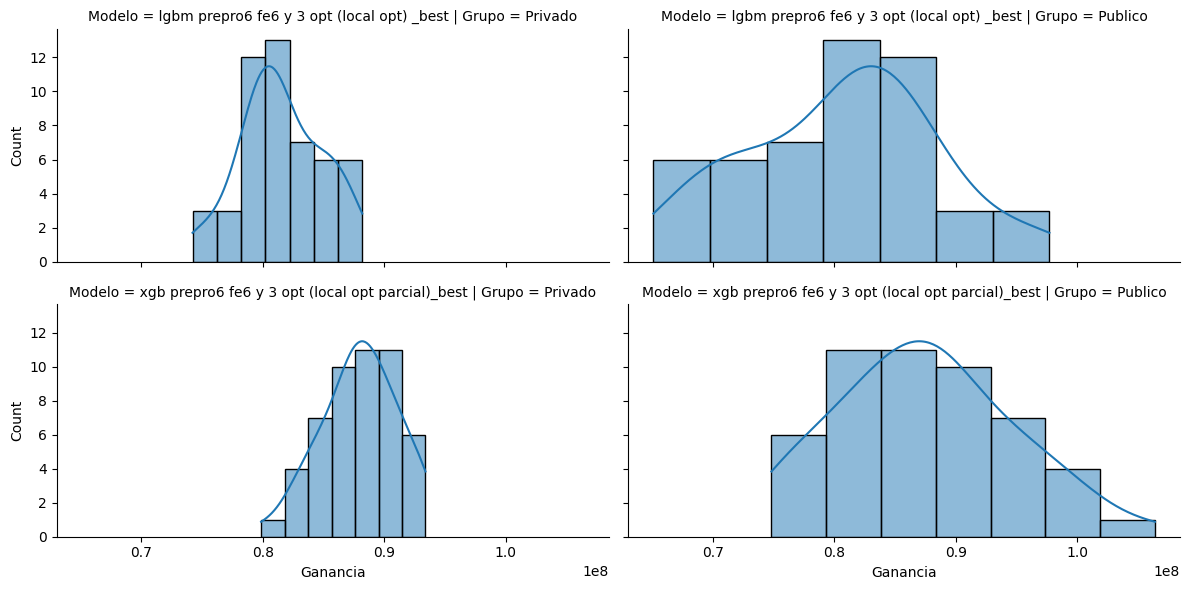

Ganancia media del modelo lgbm prepro6 fe6 y 3 opt (local opt)  privado: 81533800.0
Ganancia media del modelo lgbm prepro6 fe6 y 3 opt (local opt)  publico: 80631133.33333334
Ganancia media del modelo xgb prepro6 fe6 y 3 opt (local opt parcial) privado: 87951400.0
Ganancia media del modelo xgb prepro6 fe6 y 3 opt (local opt parcial) publico: 87496733.33333334

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 210.5
P-valor = 3.9539166732099834e-13
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de xgb prepro6 fe6 y 3 opt (local opt parcial)_priv es mayor que la de lgbm prepro6 fe6 y 3 opt (local opt) _priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 665.0
P-valor = 2.7952338122150375e-05
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de xgb prepro6 fe6 y 3 opt (local opt parcial)_pub es mayor que la de lgbm prepro6 fe6 y 3 opt (local opt) _pub.


In [22]:
model_a = "lgbm prepro6 fe6 y 3 opt (local opt) "
model_b = "xgb prepro6 fe6 y 3 opt (local opt parcial)"

plot_comparisons_on_kaggle_split(model_a, fpri_best_lgbm_pr6_fe6_tr3, fpub_best_lgbm_pr6_fe6_tr3,
                                model_b, fpri_best_xgb_pr6_fe6_tr3, fpub_best_xgb_pr6_fe6_tr3)

Comparando modelos: lgbm prepro6 fe6 y 1 opt (cloud opt)  vs. xgb prepro6 fe6 y 3 opt (local opt parcial)


c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



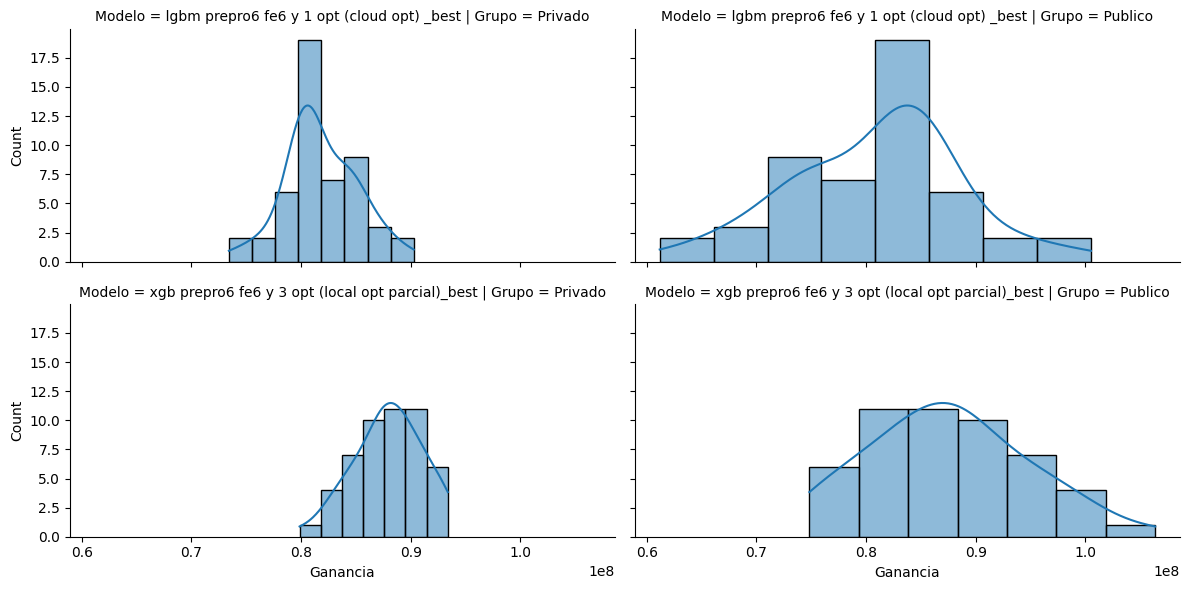

Ganancia media del modelo lgbm prepro6 fe6 y 1 opt (cloud opt)  privado: 81839200.0
Ganancia media del modelo lgbm prepro6 fe6 y 1 opt (cloud opt)  publico: 80851866.66666667
Ganancia media del modelo xgb prepro6 fe6 y 3 opt (local opt parcial) privado: 87951400.0
Ganancia media del modelo xgb prepro6 fe6 y 3 opt (local opt parcial) publico: 87496733.33333334

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 242.5
P-valor = 1.9316028911195723e-12
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de xgb prepro6 fe6 y 3 opt (local opt parcial)_priv es mayor que la de lgbm prepro6 fe6 y 1 opt (cloud opt) _priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 672.0
P-valor = 3.428340958363011e-05
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de xgb prepro6 fe6 y 3 opt (local opt parcial)_pub es mayor que la de lgbm prepro6 fe6 y 1 opt (cloud opt) _pub.


In [23]:
model_a = "lgbm prepro6 fe6 y 1 opt (cloud opt) "
model_b = "xgb prepro6 fe6 y 3 opt (local opt parcial)"

plot_comparisons_on_kaggle_split(model_a, fpri_best_lgbm_pr6_fe6_tr1, fpub_best_lgbm_pr6_fe6_tr1,
                                model_b, fpri_best_xgb_pr6_fe6_tr3, fpub_best_xgb_pr6_fe6_tr3)

> Comentario

Parece que la optimización en la nube fue más efectiva que la propia hecha localmente.

## Comparando modelos de la clase plenaria

> Modelo de Joaquin

### Corriendo pipeline con LightGBM ###

# Entrenando el modelo base LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.748975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50980
[LightGBM] [Info] Number of data points in the train set: 652447, number of used features: 405
[LightGBM] [Info] Start training from score -0.011397
[LightGBM] [Info] Start training from score -5.250505
[LightGBM] [Info] Start training from score -5.101460

# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 63308000.0

# Entrenando el mejor modelo con parámetros optimizados
[LightGBM] [Warning] min_data_in_leaf is set=912, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=912
[LightGBM] [Warning] feature_fraction is set=0.34, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34
[LightGBM] [Warning] min_data_in_leaf is set=912, min

c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



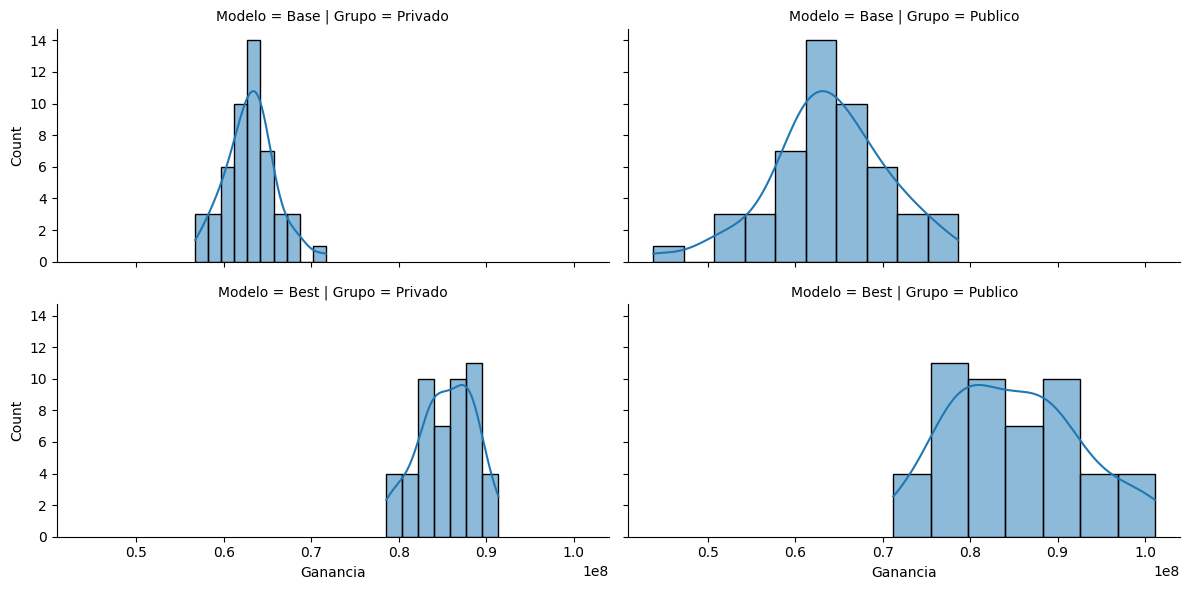

Ganancia media del modelo base en privado: 63063600.0
Ganancia media del modelo base en público: 63878266.66666667
Ganancia media del modelo Best en privado: 85454400.0
Ganancia media del modelo Best en público: 85109733.33333334


In [24]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
# training = 1 # un mes de optimización

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_joaquin = ModelPipeline(data=None, seeds=semillas,
                              model_type='lightgbm', seed=s, n_jobs=-1)

joaquin_params = {'n_estimators': 2215,
                  'num_leaves': 22,
                  'learning_rate': 0.021,
                  'min_data_in_leaf': 912,
                  'feature_fraction': 0.34, # es mucho menor, posiblemente debido a las pocas variables que vengo manejando
                  'extra_trees': False,
                  'random_state': semillas[s],
}

pipeline_joaquin.best_params = joaquin_params

print("\n# Entrenando el modelo base LightGBM")
pipeline_joaquin.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_joaquin.test_base_model(X_test_imp, y_test)

print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_joaquin.train_best_model(X_train_imp, y_train)

print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_joaquin.test_best_model(X_test_imp, y_test)

print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_pr6_fe6_joa, fpri_base_lgbm_pr6_fe6_joa, \
fpub_best_lgbm_pr6_fe6_joa, fpub_base_lgbm_pr6_fe6_joa = \
pipeline_joaquin.simulate_kaggle_split(X_test_imp, y_test) # sin imputer ni to_drop porque estan prepro

Comparo com mejor modelo logrado

Comparando modelos: xgb prepro6 fe6 y 3 opt (local opt parcial) vs. lgbm joaquin


c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



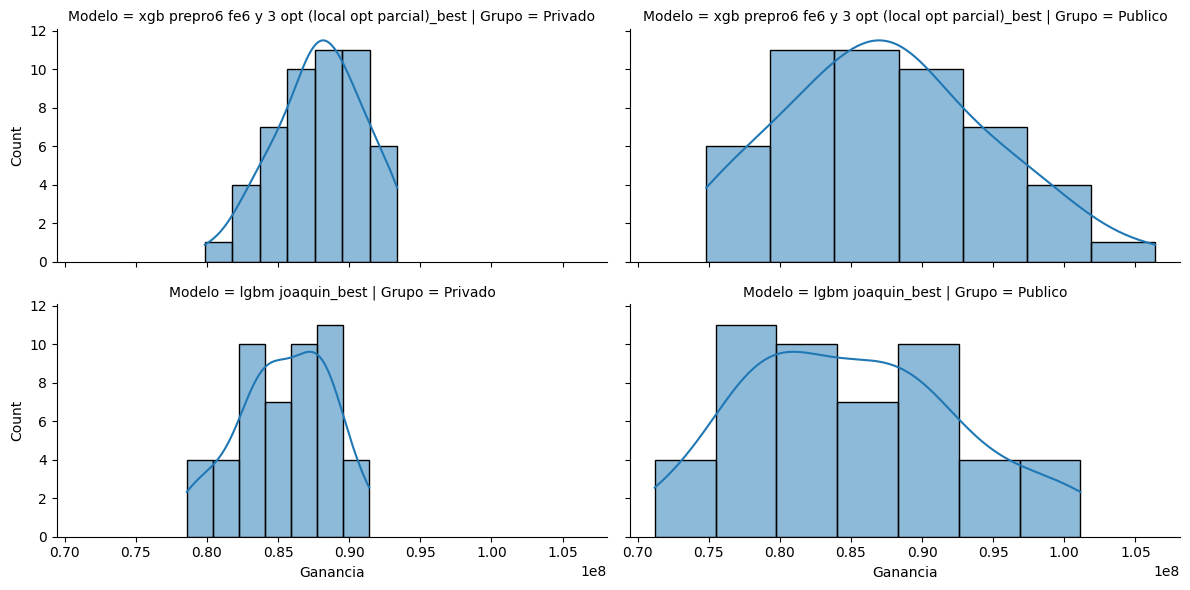

Ganancia media del modelo xgb prepro6 fe6 y 3 opt (local opt parcial) privado: 87951400.0
Ganancia media del modelo xgb prepro6 fe6 y 3 opt (local opt parcial) publico: 87496733.33333334
Ganancia media del modelo lgbm joaquin privado: 85454400.0
Ganancia media del modelo lgbm joaquin publico: 85109733.33333334

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1764.0
P-valor = 0.9998050975346814
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de lgbm joaquin_priv es mayor que la de xgb prepro6 fe6 y 3 opt (local opt parcial)_priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 1466.5
P-valor = 0.9326684036200165
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de lgbm joaquin_pub es mayor que la de xgb prepro6 fe6 y 3 opt (local opt parcial)_pub.


In [29]:
model_a = "xgb prepro6 fe6 y 3 opt (local opt parcial)"
model_b = "lgbm joaquin"

plot_comparisons_on_kaggle_split(model_a, fpri_best_xgb_pr6_fe6_tr3, fpub_best_xgb_pr6_fe6_tr3,
                                model_b, fpri_best_lgbm_pr6_fe6_joa, fpub_best_lgbm_pr6_fe6_joa)

Modelo Semillerio

### Corriendo pipeline con LightGBM ###

# Entrenando el modelo base LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.736408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50980
[LightGBM] [Info] Number of data points in the train set: 652447, number of used features: 405
[LightGBM] [Info] Start training from score -0.011397
[LightGBM] [Info] Start training from score -5.250505
[LightGBM] [Info] Start training from score -5.101460

# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 63308000.0

# Entrenando el mejor modelo con parámetros optimizados
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=711, min_c

c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



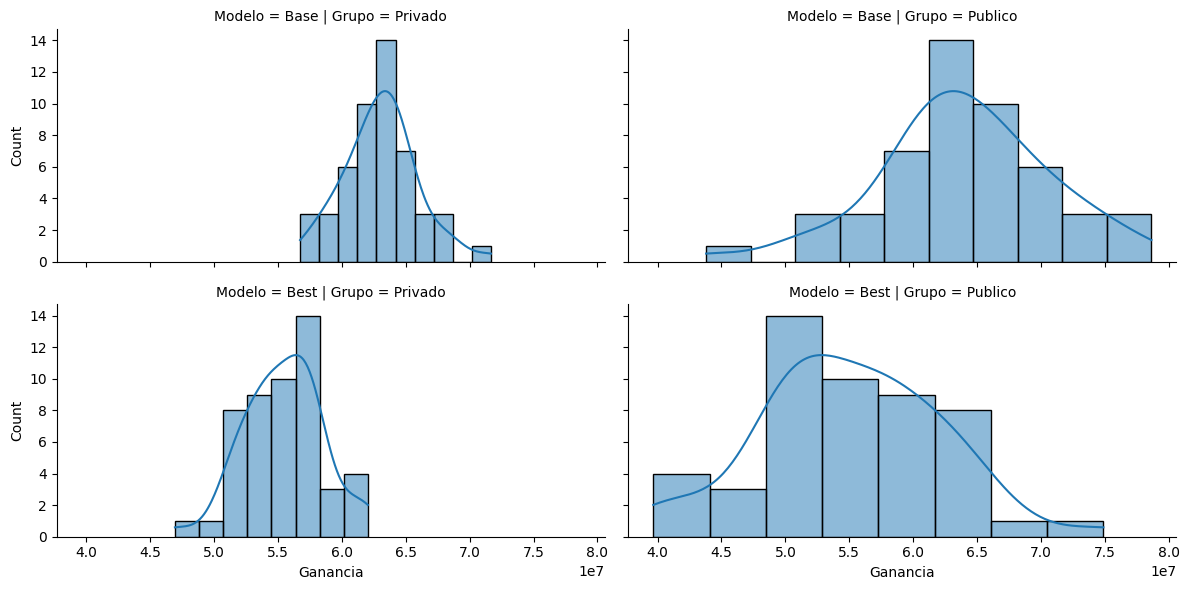

Ganancia media del modelo base en privado: 63063600.0
Ganancia media del modelo base en público: 63878266.66666667
Ganancia media del modelo Best en privado: 55458200.0
Ganancia media del modelo Best en público: 55024200.0


In [26]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
# training = 1 # un mes de optimización

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_sem = ModelPipeline(data=None, seeds=semillas,
                              model_type='lightgbm', seed=s, n_jobs=-1)

semillerio_params = {'n_estimators': 23,
                  'num_leaves': 32,
                  'learning_rate': 0.34,
                  'min_data_in_leaf': 711,
                  'feature_fraction': 0.2, # más bajo que el de joaquin
                  'extra_trees': False,
                  'random_state': semillas[s],
}

pipeline_sem.best_params = semillerio_params

print("\n# Entrenando el modelo base LightGBM")
pipeline_sem.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_sem.test_base_model(X_test_imp, y_test)

print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_sem.train_best_model(X_train_imp, y_train)

print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_sem.test_best_model(X_test_imp, y_test)

print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_pr6_fe6_sem, fpri_base_lgbm_pr6_fe6_sem, \
fpub_best_lgbm_pr6_fe6_sem, fpub_base_lgbm_pr6_fe6_sem = \
pipeline_sem.simulate_kaggle_split(X_test_imp, y_test) # sin imputer ni to_drop porque estan prepro

Semillerío x2 en 'feature_fraction'

### Corriendo pipeline con LightGBM ###

# Entrenando el modelo base LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.769651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50980
[LightGBM] [Info] Number of data points in the train set: 652447, number of used features: 405
[LightGBM] [Info] Start training from score -0.011397
[LightGBM] [Info] Start training from score -5.250505
[LightGBM] [Info] Start training from score -5.101460

# Evaluando el modelo base en el conjunto de prueba
Ganancia del modelo en el conjunto de test: 63308000.0

# Entrenando el mejor modelo con parámetros optimizados
[LightGBM] [Warning] min_data_in_leaf is set=711, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=711
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=711, min_c

c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



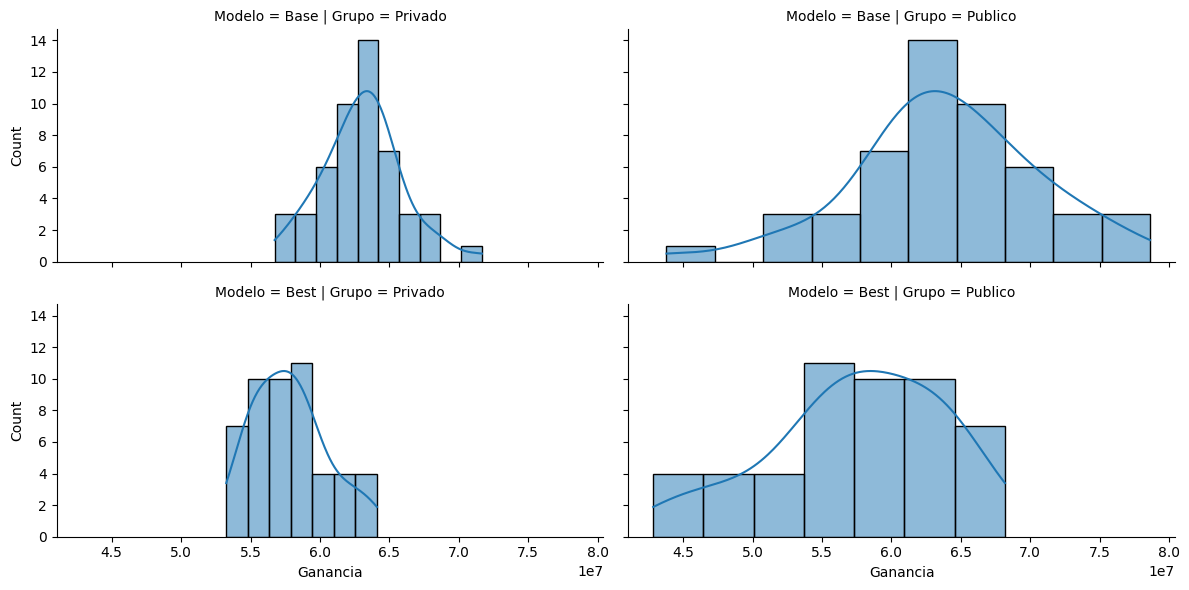

Ganancia media del modelo base en privado: 63063600.0
Ganancia media del modelo base en público: 63878266.66666667
Ganancia media del modelo Best en privado: 57829800.0
Ganancia media del modelo Best en público: 57493800.0


In [27]:
# Condiciones de la optimización
s = 1
prepro = 6 # data quality + data drifting
fe = 6 # feature engineering conceptual 6 meses
# training = 1 # un mes de optimización

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_sem = ModelPipeline(data=None, seeds=semillas,
                              model_type='lightgbm', seed=s, n_jobs=-1)

semillerio_params = {'n_estimators': 23,
                  'num_leaves': 32,
                  'learning_rate': 0.34,
                  'min_data_in_leaf': 711,
                  'feature_fraction': 2*0.2, # x2 para tratar de compenzar la falta de variables
                  'extra_trees': False,
                  'random_state': semillas[s],
}

pipeline_sem.best_params = semillerio_params

print("\n# Entrenando el modelo base LightGBM")
pipeline_sem.train_base_model(X_train_imp, y_train)

print("\n# Evaluando el modelo base en el conjunto de prueba")
pipeline_sem.test_base_model(X_test_imp, y_test)

print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_sem.train_best_model(X_train_imp, y_train)

print("\n# Evaluando el mejor modelo en el conjunto de prueba")
pipeline_sem.test_best_model(X_test_imp, y_test)

print("\n# Simulando el split Kaggle y comparando modelos")

fpri_best_lgbm_pr6_fe6_sem_x, fpri_base_lgbm_pr6_fe6_sem_x, \
fpub_best_lgbm_pr6_fe6_sem_x, fpub_base_lgbm_pr6_fe6_sem_x = \
pipeline_sem.simulate_kaggle_split(X_test_imp, y_test) # sin imputer ni to_drop porque estan prepro

Comparos modelos para semilleríos

Comparando modelos: lgbm para semillerío vs. lgbm para semillerío x


c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning:

The figure layout has changed to tight



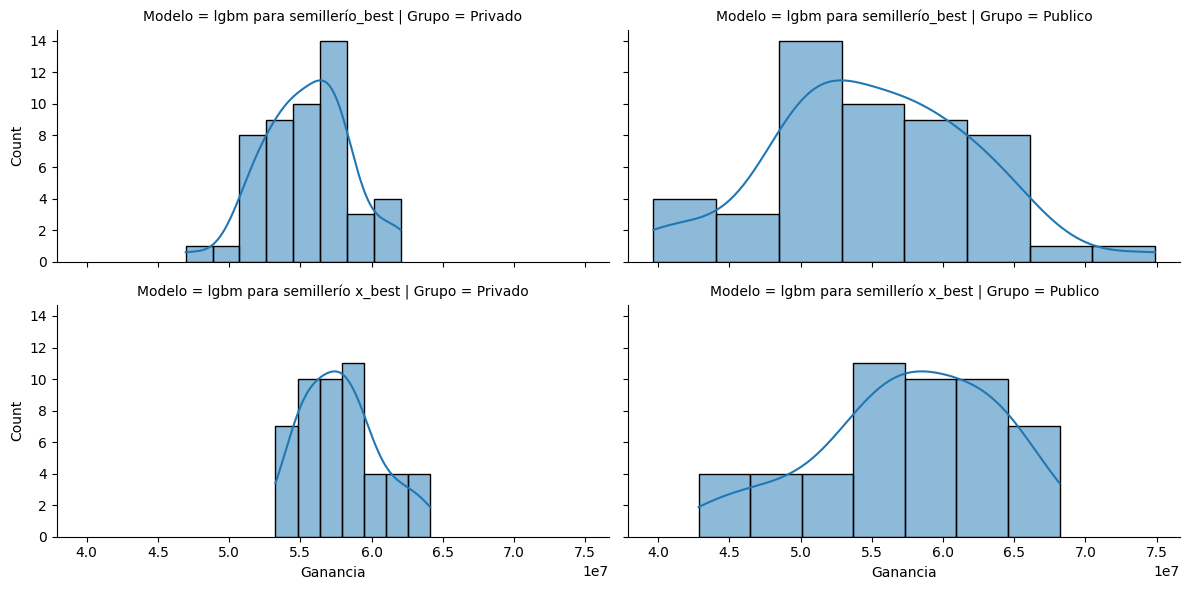

Ganancia media del modelo lgbm para semillerío privado: 55458200.0
Ganancia media del modelo lgbm para semillerío publico: 55024200.0
Ganancia media del modelo lgbm para semillerío x privado: 57829800.0
Ganancia media del modelo lgbm para semillerío x publico: 57493800.0

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 705.0
P-valor = 8.711518749085171e-05
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de lgbm para semillerío x_priv es mayor que la de lgbm para semillerío_priv.

Resultado del test estadístico Mann-Whitney U (privado):
Estadístico U = 960.5
P-valor = 0.023167655910205642
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de lgbm para semillerío x_pub es mayor que la de lgbm para semillerío_pub.


In [28]:
model_a = "lgbm para semillerío"
model_b = "lgbm para semillerío x"

plot_comparisons_on_kaggle_split(model_a, fpri_best_lgbm_pr6_fe6_sem, fpub_best_lgbm_pr6_fe6_sem,
                                model_b, fpri_best_lgbm_pr6_fe6_sem_x, fpub_best_lgbm_pr6_fe6_sem_x)

___